In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cpu")

In [21]:
!ls ..

LICENSE          chapter1         data             requirements.txt
README.md        chapter2         my-python3-env   spamdata_v2.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
df = pd.read_csv("../spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


The dataset consists of two columns – `label` and `text`. The column `text` contains the message body and the `label` is a binary variable where 1 means spam and 0 means the message is not a spam.

In [23]:
# Lets look at class distribution

df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

86% is not spam, 13% is spam

In [24]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


In [25]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Plot length of sentences

<Axes: >

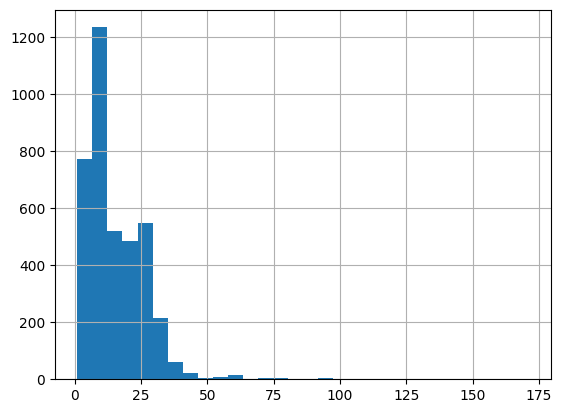

In [26]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

### Tokenize and Encode in Training, Validation and Test Set

Which Tokenization strategy is used by BERT?
BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.

WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT, Funnel Transformers, and MPNET. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.

Reference: https://huggingface.co/learn/nlp-course/en/chapter6/6

What is the maximum sequence length of the input?
The maximum sequence length of the input = 512

In [27]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/rdua/work/github/rajdeepd/bpb-vector-databases/my-python3-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Convert List to Tensors

In [28]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

attention_mask is required for training the model.

## Data Loader

### TensorDataset class

Loading your data into a PyTorch dataset will be one of the first steps you take in order to create and train a neural network with PyTorch.

The `TensorDataset` class is very helpful when your dataset can be loaded directly as a NumPy array. Recall that `TensorDataset()` can take one or more NumPy arrays as input.

In this case we are loading `train_seq`, `train_mask` and `train_y`

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [30]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [31]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

The thought process behind the provided code for the `BERT_Arch` class, which extends `nn.Module` from PyTorch, involves designing a neural network architecture that fine-tunes a pre-existing BERT model for a specific task, such as binary classification. The architecture leverages pre-trained BERT model for feature extraction and then tailors it to a specific task through additional layers and functions. Here's a detailed breakdown of the thought process:

### Integrating BERT Model

- **BERT as the Backbone**: The BERT model is utilized as the backbone for extracting contextual representations of the input text. Given its success in understanding complex language nuances, it serves as a solid foundation for feature extraction.

### Custom Architecture for Specific Tasks

- **Dropout for Regularization**: A dropout layer with a rate of 0.1 is introduced immediately after the BERT layer. This is a common technique to prevent overfitting by randomly zeroing out a fraction of the output units during training, forcing the model to learn robust features that are not reliant on a small set of neurons.

- **Activation Function**: The ReLU activation function is used to introduce non-linearity into the network, enabling it to learn complex mappings from inputs to outputs. ReLU is preferred for its computational efficiency and its ability to mitigate the vanishing gradient problem.

- **Dense Layers for Dimensionality Reduction and Decision Making**: 
  - The first dense layer (`fc1`) reduces the dimensionality from the BERT output size (768) to a smaller size (512), making the network computationally less expensive and potentially capturing more relevant, condensed information for the task.
  - The second dense layer (`fc2`) acts as the output layer, further reducing the dimensionality from 512 to 2, which likely corresponds to the two classes in a binary classification task.

### Output Processing for Classification

- **Softmax for Probabilities**: The LogSoftmax function is used at the end to convert the logits from the final dense layer into log probabilities. This step is crucial for classification tasks as it provides a probabilistic interpretation of the model's predictions, facilitating the calculation of loss during training and making the model's outputs interpretable.

### Forward Pass Definition

- **Utilizing BERT's Output**: In the forward pass, the BERT model processes the input (`sent_id` and `mask`), but only the [CLS] token's representation (`cls_hs`) is used for downstream tasks. This token's output is particularly useful for classification tasks as it contains aggregated information about the entire input sequence.

- **Sequential Processing through Layers**: The extracted features from the BERT model are then sequentially processed through the defined layers (dense, activation, dropout) to gradually transform the feature space from BERT's output to the final classification logits.

- **End-to-End Training Capability**: By defining this architecture and forward pass, the model can be trained end-to-end, allowing the additional layers (and potentially the BERT model itself, depending on the training setup) to be fine-tuned specifically for the classification task at hand.

This architecture demonstrates a practical approach to leveraging a pre-trained language model like BERT for specific downstream tasks, utilizing a combination of pre-existing deep learning techniques and custom layers to adapt to new challenges.


In [32]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [41]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/Users/rdua/work/github/rajdeepd/bpb-vector-databases/my-python3-env/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Compute Class Weight

The `compute_class_weight` function is designed to compute class weights. In the context of machine learning, particularly in classification problems, datasets may exhibit class imbalance, where some classes have many more instances than others. Training a model on such imbalanced data can lead to poor generalization performance, as the model may become biased towards the majority class(es) and not learn enough about the minority class(es).

Class weights can be used to address this issue by assigning a higher weight to the minority classes and a lower weight to the majority classes. This makes the model pay more attention to the minority classes during training, helping to improve the model's performance on imbalanced datasets.

How `compute_class_weight` Works?
compute_class_weight takes the following parameters:

`class_weight`: This can be set to different modes, such as `balanced`, which automatically adjusts weights inversely proportional to class frequencies in the input data.
`classes`: An array of the unique classes present in the dataset.
`y`: The target class labels for the training data.

The function returns an array of weights for each class, which can then be used in various classifiers in scikit-learn that accept the class_weight parameter. This parameter is used to modify the learning algorithm so that it treats instances of different classes with the weights specified.

In [35]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [36]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10


The provided function, train(), is designed to train a model, presumably a BERT model or a similar neural network, for a certain task (like classification) using a dataset provided via a train_dataloader. Here's a step-by-step breakdown of what happens within the function:

Model Training Mode: The function starts by setting the model to training mode with model.train(). This is essential because certain layers like dropout and batch normalization work differently during training and inference.

Initialization: It initializes variables to accumulate total loss (total_loss) and store predictions from the model (total_preds).

Batch Iteration: The function iterates over batches of data provided by train_dataloader. For each batch:

It optionally prints a progress update after every 50 batches.
Moves the batch data to the same device (CPU or GPU) as the model with batch = [r.to(device) for r in batch] to ensure the data and model are compatible for computation.
Extracts sentence IDs (sent_id), attention masks (mask), and labels from the batch.
Gradient Zeroing: Before processing each batch, it clears out old gradients from the previous step to prevent them from accumulating with model.zero_grad().

Model Prediction: The model makes predictions for the current batch with preds = model(sent_id, mask).

Loss Computation: The function calculates the loss using a cross_entropy loss function, comparing the model's predictions (preds) against the actual labels (labels).

Loss Accumulation: Adds the loss of the current batch to the total loss.

Backward Propagation: Performs backpropagation with loss.backward() to calculate gradients for each model parameter.

Gradient Clipping: Applies gradient clipping (torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)) to prevent the exploding gradient problem, ensuring that gradients do not exceed a certain threshold.

Parameter Update: Updates the model's parameters based on the gradients calculated during backpropagation using the optimizer with optimizer.step().

Detach Predictions: Detaches predictions from the computation graph and moves them to CPU memory with preds=preds.detach().cpu().numpy(). This step is necessary because PyTorch tracks operations on tensors for automatic gradient computation, and detaching them prevents unnecessary memory usage for tensors that are no longer needed in the computation graph.

Store Predictions: Appends the predictions of the current batch to total_preds.

Epoch Loss Calculation: After processing all batches, calculates the average loss for the epoch by dividing the total loss by the number of batches.

Prediction Reshaping: Concatenates all batch predictions stored in total_preds into a single numpy array to match the shape expected for evaluation or further processing.

Return Values: Returns the average loss

In [37]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [39]:
#function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [42]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.673
Validation Loss: 0.649

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.640
Validation Loss: 0.615

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.613
Validation Loss: 0.590

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.590
Validation Loss: 0.564

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.541

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.543
Validation Loss: 0.519

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.522
Validation Loss: 0.499

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.510
Validat

<function matplotlib.pyplot.show(close=None, block=None)>

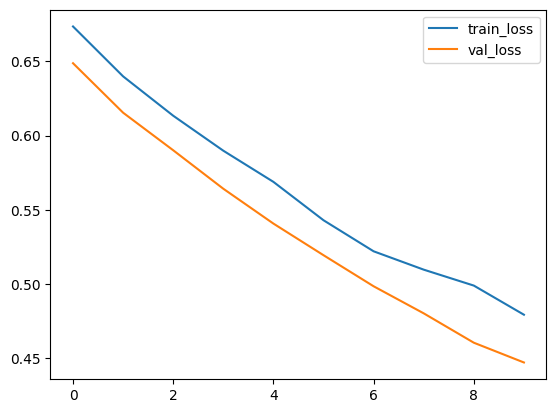

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train_loss')
plt.plot(valid_losses,label='val_loss')
plt.legend()
plt.show

In [43]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Make Predictions

In [44]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [45]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       724
           1       0.43      0.88      0.58       112

    accuracy                           0.83       836
   macro avg       0.71      0.85      0.74       836
weighted avg       0.90      0.83      0.85       836



BERT was undoubtedly a breakthrough in the use of Machine Learning for Natural Language Processing when it was proposed . The fact that it’s approachable and allowed fast fine-tuning allowed a wide range of practical applications till more refined versions came up. In this Notebook we have discussed about BERT 